## Protocol 1: Verifying the Performance of an Arduino Board

This protocol aims to verify the temporal precision and stability of an Arduino board by generating and analyzing a periodic signal (triggers).

### Prerequisites

**Hardware:**
*   An Arduino board (e.g., Uno, Nano, etc.; here, a Leonardo)
*   A USB cable (micro-USB or USB-C depending on the board)
*   A digital oscilloscope or an acquisition device (here, an Analog Discovery 3)

**Software:**
*   **Arduino IDE** (here, version `1.8.19`)
*   Acquisition and measurement software (here, **Digilent Waveforms**, version `3.24.2`)
*   A **Python 3** environment with the necessary libraries (`pandas`, `numpy`, `matplotlib`, `scipy`).

### Steps to Follow

#### 1. Generating Triggers on Arduino

1.  **Prepare the Arduino code (.ino)** that generates triggers on a pin (here, pin 8), taking the desired period as an argument.

    > **Arduino (.ino) code for automatic periodic trigger generation via TimerOne.**
    >
    >     // Uses the TimerOne library: https://www.pjrc.com/teensy/td_libs_TimerOne.html
    >     #include <TimerOne.h>
    >
    >     const int triggerPin = 8;       // TTL output on pin 8
    >     const unsigned long period_us = 500000;   // Period = 500 ms
    >     const unsigned long pulse_width_us = 1000; // Pulse width = 1 ms
    >
    >     void setup() {
    >       pinMode(triggerPin, OUTPUT);
    >       digitalWrite(triggerPin, LOW);
    >
    >       Timer1.initialize(period_us);         // Timer triggered every 500 ms
    >       Timer1.attachInterrupt(trigger);      // Function called at each tick
    >     }
    >
    >     void loop() {
    >       // The timer does everything, nothing to do here
    >     }
    >
    >     void trigger() {
    >       digitalWrite(triggerPin, HIGH);
    >       delayMicroseconds(pulse_width_us);    // 1 ms pulse
    >       digitalWrite(triggerPin, LOW);
    >     }

2.  **Connect the Arduino board** to the computer via the USB port.

3.  **Open the Arduino IDE** and verify that the board is correctly recognized (`Tools > Board > "your_arduino_board_name"`) and that the correct port is selected (`Tools > Port`).
    > *[Image: Arduino IDE "Tools" menu expanded, showing board and port selection.]*

4.  **Verify and then upload the code** to the board using the dedicated buttons.
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/verify_button_ide_arduino.png)
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/upload_button_ide_arduino.png)
    
5.  Wait for the confirmation message `Done uploading.` to appear at the bottom of the window.
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/done_uploading_ide_arduino.png)

The board should now be generating triggers on the specified pin.

#### 2. Measuring the Triggers

1.  **Connect the oscilloscope** to the Arduino board:
    *   Connect the ground probe (GND) of the oscilloscope to one of the **GND** pins on the Arduino.
    *   Connect the measurement probe (Channel 1) to **pin 8** of the Arduino.

2.  **Launch the Waveforms software** (or equivalent). Click **`Scope`**
    >![Scope settings](/home/neurostim/mirian/stimisation/pictures/welcome_page_waveforms.png)
    >![Scope settings](/home/neurostim/mirian/stimisation/pictures/scope_opened.png)

3.  Click **`Run`** to start the acquisition. You should observe peaks/square waves on the channel corresponding to your connections.
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/acquisition_triggers_peaks.png)

4.  You can visually inspect the signal (period, amplitude, duty cycle) by **changing the axis scales**.
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/acquisition_characteristics_one_channel.png)
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/acquisition_triggers.png)

#### 3. Recording the Signal

1.  Click the **`Record`** button.
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/record_button.png)

2.  Configure the recording settings:
    *   **File format:** `.csv`
    *   **Sampling rate:** `10 kHz`
    *   **Recording duration:** `20 s`
    *   **Location and name of your file.**
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/choice_of_recording_characteristics_two_channels.png)

3.  Start the recording. You will now have a `.csv` file containing the measured signal.

#### 4. Analyzing the Signal

1.  **Prepare the Python script**. The code should allow for the analysis of the `.csv` file by choosing a detection threshold, a minimum interval between peaks, and other parameters. It should study the minimum, maximum, and average intervals, generate a histogram of the interval distribution, and count the number of peaks and intervals.

    > **Python (.py) code for analyzing trigger regularity from a CSV file.**
    >
    >     import numpy as np
    >     import matplotlib
    >     matplotlib.use('Agg')  # Use a non-interactive backend
    >
    >     import matplotlib.pyplot as plt
    >     from scipy.signal import find_peaks
    >     import os
    >
    >     # --- Parameters ---
    >     NOM_FICHIER_CSV = 'triggers_arduino_better_500ms.csv'
    >     COLONNE_SIGNAUX = 0           # index of the column to analyze
    >     SAMPLING_RATE = 10000         # Hz (sampling rate used during acquisition)
    >     DISTANCE_MIN_MS = 1.0         # Minimum distance between two peaks (in ms)
    >
    >     def analyser_et_sauvegarder_graphique_csv(nom_fichier):
    >         try:
    >             data = np.loadtxt(nom_fichier, delimiter=',')
    >
    >             print(f"--- Analyzing CSV file: {nom_fichier} ---")
    >             print(f"Sampling rate used: {SAMPLING_RATE} Hz")
    >
    >             # Handle 1D or 2D
    >             if data.ndim == 1:
    >                 signal = data
    >                 print("The file contains a single column, which will be used.")
    >             else:
    >                 signal = data[:, COLONNE_SIGNAUX]
    >                 print(f"The file contains {data.shape[1]} columns, using column {COLONNE_SIGNAUX}.")
    >
    >             signal_abs = np.abs(signal)
    >             seuil = 0.5 * np.max(signal_abs)
    >             print(f"Detection threshold (absolute): {seuil:.2f}")
    >
    >             distance_min_samples = int(DISTANCE_MIN_MS * SAMPLING_RATE / 1000)
    >             print(f"Minimum distance between peaks: {DISTANCE_MIN_MS} ms")
    >
    >             indices_pics, _ = find_peaks(signal_abs, height=seuil, distance=distance_min_samples)
    >             intervalles_en_samples = np.diff(indices_pics)
    >             intervalles_en_ms = (intervalles_en_samples / SAMPLING_RATE) * 1000
    >
    >             print("\n--- RESULTS ---")
    >             print(f"Number of peaks detected: {len(indices_pics)}")
    >             print(f"Total number of intervals: {len(intervalles_en_ms)}")
    >
    >             if len(intervalles_en_ms) > 0:
    >                 moyenne = np.mean(intervalles_en_ms)
    >                 print(f"Average interval: {moyenne:.2f} ms")
    >                 print(f"Min interval: {np.min(intervalles_en_ms):.2f} ms")
    >                 print(f"Max interval: {np.max(intervalles_en_ms):.2f} ms")
    >
    >                 plt.figure(figsize=(12, 7))
    >                 plt.hist(intervalles_en_ms, bins=50, edgecolor='black', alpha=0.75)
    >                 plt.axvline(moyenne, color='red', linestyle='--', linewidth=2,
    >                             label=f'Average = {moyenne:.2f} ms')
    >                 plt.title(f"Interval Distribution\nFile: {os.path.basename(nom_fichier)}")
    >                 # ... [rest of the code to save the plot]

2.  **Run the code**.
    >![Scope settings](/home/neurostim/mirian/stimisation/pictures/analyze_and_draw_triggers_csv.png)

3.  The various characteristics of the signal will now be displayed in the terminal, and you can find the histogram at the specified file path.
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/command_results_triggers_csv.png)
    > ![Scope settings](/home/neurostim/mirian/stimisation/pictures/results_plot_arduino.png)

#### To Go Further

Repeat this protocol, varying the period in your Arduino code, to study the performance more thoroughly.

---

## Protocol 2: Studying the Synchronization between Triggers and Visual Stimuli

This protocol aims to measure the delay and jitter between a trigger sent by an Arduino board and the actual appearance of a visual stimulus on a screen.

### Prerequisites

**Hardware:**
*   All the hardware from Protocol 1.
*   **Two computer screens.**
*   A **photodiode** with its power supply circuit.

**Software:**
*   All the software from Protocol 1.
*   **Python 3** with the necessary additional libraries (e.g., `pyserial`, `expyriment`).

### Steps to Follow

#### 1. Generating Triggers and Stimuli

1.  **Set up two screens**: one for the recording window (Waveforms) and the other for displaying the visual stimuli.

2.  **Prepare the associated .ino and .py code**. This setup generates triggers on a pin (here, pin 8) each time a visual stimulus is presented, taking the desired period as an argument.

> **Arduino (.ino) code for receiving serial commands.**
>
> ```arduino
> const int triggerPin = 8;
> 
> void setup() {
>     Serial.begin(115200);
>     pinMode(triggerPin, OUTPUT);
>     digitalWrite(triggerPin, LOW);
> }
> 
> void loop() {
>     if (Serial.available()) {
>         String cmd = Serial.readStringUntil('\n');
>         if (cmd == "TRIG") {
>             digitalWrite(triggerPin, HIGH);
>             delayMicroseconds(1000);  // 1 ms pulse
>             digitalWrite(triggerPin, LOW);
>         }
>     }
> }
> ```

3.  **Upload the `.ino` code** to your Arduino board by following steps 2 to 5 from Protocol 1.

4.  **Prepare your Python script (.py)** that displays the stimuli and sends commands to the Arduino.

> **Python (.py) code for displaying stimuli and sending triggers.**
>
>     from expyriment import design, control, stimuli, misc
>     import serial
>     import time
>
>     # --- Setup Arduino ---
>     arduino = serial.Serial('/dev/ttyACM0', 115200)
>     time.sleep(2)  # Allow time for the Arduino to reboot
>
>     # --- Setup Expyriment ---
>     exp = design.Experiment(name="Stimuli_Trigger_Sync")
>     control.set_develop_mode(True)
>     control.initialize(exp)
>
>     PERIOD = 500  # Total interval in ms
>     SQUARE_DURATION = 100  # ms
>
>     square = stimuli.Rectangle((400, 400), position=(0, 0))
>     blank = stimuli.BlankScreen()
>     square.preload()
>     blank.preload()
>
>     exp.add_data_variable_names(['trial', 'stimulus_time', 'trigger_time'])
>
>     control.start(skip_ready_screen=True)
>     clock = misc.Clock()
>     clock2 = misc.Clock()
>     i = 1
>
>     while i <= 10000:
>         while (clock2.time < i * PERIOD - 3):
>             pass
>
>         stim_time = clock2.time + square.present(update=True)
>         arduino.write(b'TRIG\n')  # Send TTL trigger
>         trig_time = clock2.time
>
>         while (clock2.time - stim_time < SQUARE_DURATION - 3):
>             pass
>         blank.present(update=True)
>
>         exp.data.add([i, stim_time, trig_time])
>         i += 1
>         exp.keyboard.process_control_keys()
>
>     control.end()
>     arduino.close()

5.  **Run the .py code** in your computer's terminal.
    > ![Screenshot from 2025-06-16 15-12-26.png](<attachment:Screenshot from 2025-06-16 15-12-26.png>)

6.  You should now have a window presenting the stimuli. **Place this window on the secondary screen**. The Arduino board should now be generating triggers on the specified pin.

#### 2. Measuring the Signals

1.  **Connect the oscilloscope probes:**
    *   **Channel 1 (Arduino Trigger):**
        *   Oscilloscope's GND pin to the Arduino's GND.
        *   Measurement probe to **pin 8** of the Arduino.
    *   **Channel 2 (Photodiode):**
        *   Oscilloscope's GND pin to the photodiode's GND.
        *   Measurement probe to the photodiode's output (Vout).

2.  **Place the photodiode** over the area of the window where the stimuli are presented.

3.  You should now observe two signals in Waveforms:
    *   **Channel 1:** A signal of peaks/square waves (Arduino triggers).
    *   **Channel 2:** Another signal that varies with the light intensity (photodiode).
    Both signals should be square waves with the same period but a different duty cycle.
    > ![Screenshot from 2025-06-16 16-17-33.png](<attachment:Screenshot from 2025-06-16 16-17-33.png>)

4.  **Adjust the scales** and start the acquisition with the **`Run`** button.
    > ![Screenshot from 2025-06-16 15-22-47.png](<attachment:Screenshot from 2025-06-16 15-22-47.png>)
#### 3. Recording the Signals

1.  Follow the same procedure as in Protocol 1, making sure to record both channels. You will obtain a multi-column `.csv` file.
    > ![Screenshot from 2025-06-16 16-18-08.png](<attachment:Screenshot from 2025-06-16 16-18-08.png>)

#### 4. Analyzing the Signals

1.  **Prepare your Python code** to analyze the two-column `.csv` file. This code must detect the peaks on both signals and analyze the intervals between a rising edge of the Arduino trigger and the corresponding photodiode peak.

    > **Python (.py) code for synchronization analysis (Arduino and photodiode).**
    > ```python
    >
    >     import numpy as np
    >     import matplotlib
    >     matplotlib.use('Agg')
    >     import matplotlib.pyplot as plt
    >     from scipy.signal import find_peaks
    >     import os
    >
    >     # === Global Parameters ===
    >     NOM_FICHIER_CSV = 'expy_trigger_sync.csv'
    >     SAMPLING_RATE = 10000      # Hz
    >     DISTANCE_MIN_MS = 1.0      # ms
    >
    >     def analyser_signaux_csv(fichier_csv):
    >         try:
    >             data = np.loadtxt(fichier_csv, delimiter=',')
    >             if data.shape[1] < 2:
    >                 raise ValueError("The file must contain at least 2 columns (Arduino, Photodiode).")
    >
    >             ttl = data[:, 0]
    >             photodiode = data[:, 1]
    >
    >             # Dynamic thresholds (50% of the max of each signal)
    >             seuil_ttl = 0.5 * np.max(ttl)
    >             seuil_photo = 0.5 * np.max(photodiode)
    >             print(f"TTL Threshold: {seuil_ttl:.2f}, Photodiode Threshold: {seuil_photo:.2f}")
    >
    >             min_distance_samples = int((DISTANCE_MIN_MS / 1000) * SAMPLING_RATE)
    >
    >             # Peak detection
    >             ttl_peaks, _ = find_peaks(ttl, height=seuil_ttl, distance=min_distance_samples)
    >             photo_peaks, _ = find_peaks(photodiode, height=seuil_photo, distance=min_distance_samples)
    >
    >             # Intra-trigger intervals
    >             def analyse_intervalles(peaks, label):
    >                 intervalles = np.diff(peaks) / SAMPLING_RATE * 1000  # ms
    >                 moyenne = np.mean(intervalles)
    >                 print(f"\n--- {label} ---")
    >                 print(f"Number of triggers: {len(peaks)}")
    >                 print(f"Average interval: {moyenne:.2f} ms")
    >                 print(f"Min: {np.min(intervalles):.2f}, Max: {np.max(intervalles):.2f}, Std Dev: {np.std(intervalles):.2f}")
    >
    >                 plt.figure(figsize=(10, 5))
    >                 plt.hist(intervalles, bins=40, edgecolor='black', alpha=0.8)
    >                 plt.axvline(moyenne, color='red', linestyle='--', label=f'Average = {moyenne:.2f} ms')
    >                 plt.title(f'Intervals between triggers - {label}')
    >                 plt.xlabel("Duration (ms)")
    >                 plt.ylabel("Occurrences")
    >                 plt.legend()
    >                 os.makedirs('figures', exist_ok=True)
    >                 plt.savefig(f'figures/hist_intervalles_{label.lower().replace(" ", "_")}.png')
    >                 plt.close()
    >
    >             analyse_intervalles(ttl_peaks, "Arduino")
    >             analyse_intervalles(photo_peaks, "Photodiode")
    >
    >             # Delay Arduino -> Photodiode
    >             matched_delays = []
    >             for t in ttl_peaks:
    >                 deltas = photo_peaks - t
    >                 pos_deltas = deltas[deltas > 0]
    >                 if len(pos_deltas) > 0:
    >                     delay = pos_deltas[0] / SAMPLING_RATE * 1000
    >                     matched_delays.append(delay)
    >
    >             matched_delays = np.array(matched_delays)
    >             print("\n--- Delay between Arduino trigger and visual detection ---")
    >             print(f"Number of pairings: {len(matched_delays)}")
    >             print(f"Average delay: {np.mean(matched_delays):.2f} ms, Min: {np.min(matched_delays):.2f}, Max: {np.max(matched_delays):.2f}, Jitter: {np.std(matched_delays):.2f} ms")
    >
    >             plt.figure(figsize=(10, 5))
    >             plt.hist(matched_delays, bins=30, edgecolor='black', alpha=0.8)
    >             plt.axvline(np.mean(matched_delays), color='red', linestyle='--', label=f'Average = {np.mean(matched_delays):.2f} ms')
    >             plt.title("Delay between Arduino trigger and photodiode")
    >             plt.xlabel("Delay (ms)")
    >             plt.ylabel("Occurrences")
    >             plt.legend()
    >             plt.savefig('figures/delai_arduino_vs_photodiode.png')
    >             plt.close()
    >
    >         except Exception as e:
    >             print(f"Error: {e}")
    >
    >     if __name__ == '__main__':
    >         analyser_signaux_csv(NOM_FICHIER_CSV)
    > ```

2.  **Run the code**.
>![Screenshot from 2025-06-16 15-01-08.png](<attachment:Screenshot from 2025-06-16 15-01-08.png>)

3.  The characteristics of both signals and of the latency intervals will now be displayed in the terminal, and you can find the corresponding histograms at the specified file path.
    >![Screenshot from 2025-06-16 14-48-56.png](<attachment:Screenshot from 2025-06-16 14-48-56.png>)
    >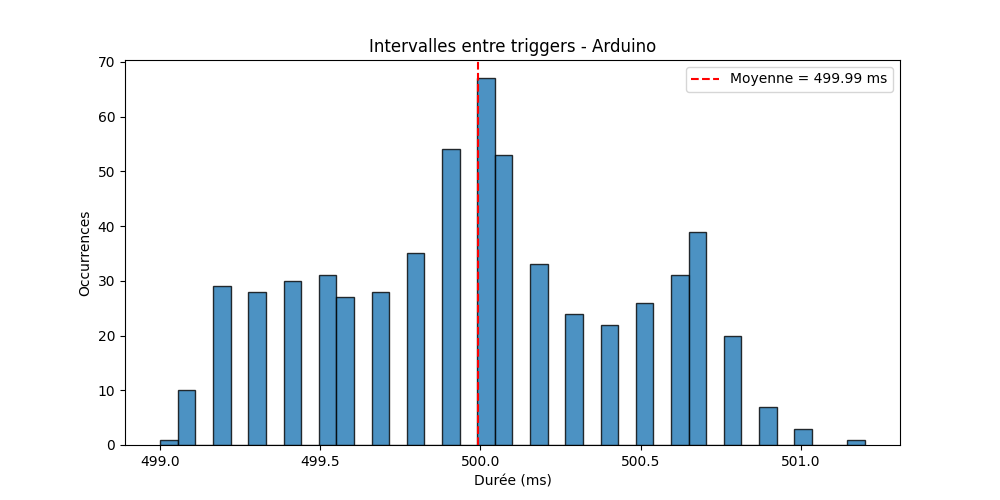
    >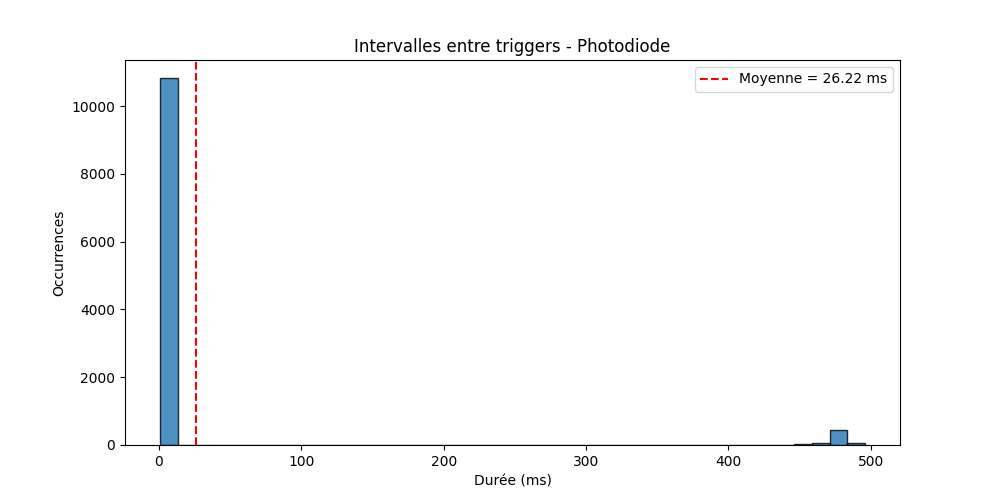
    >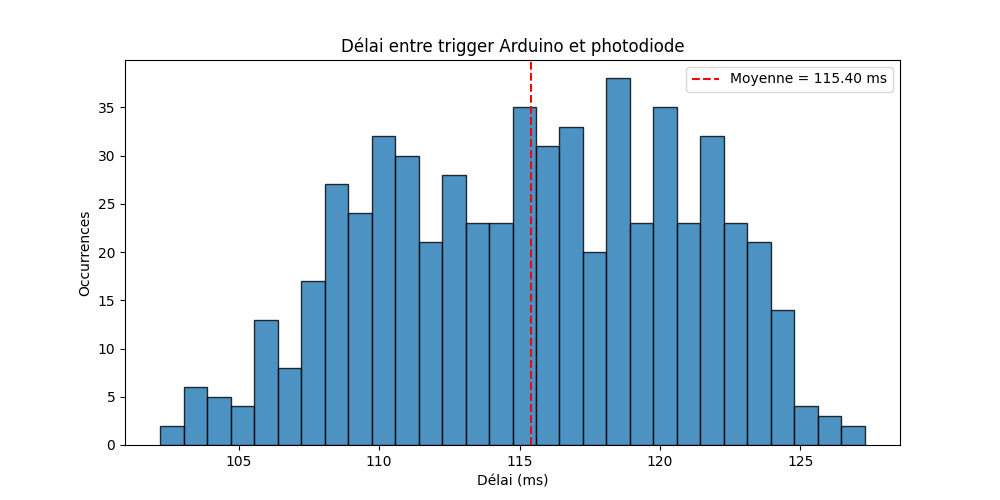
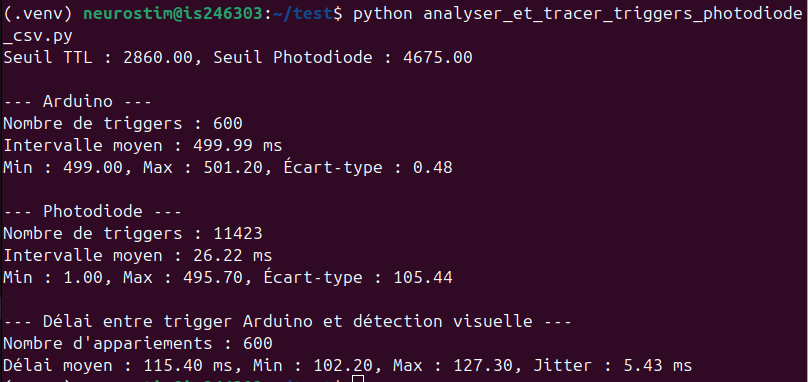
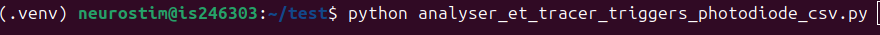
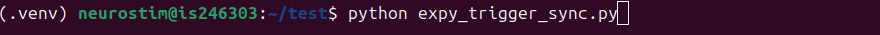
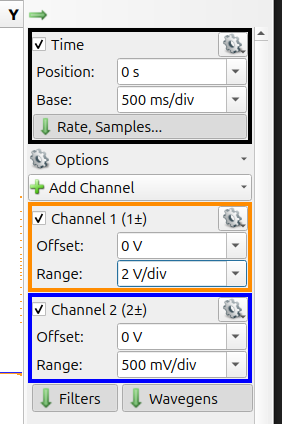
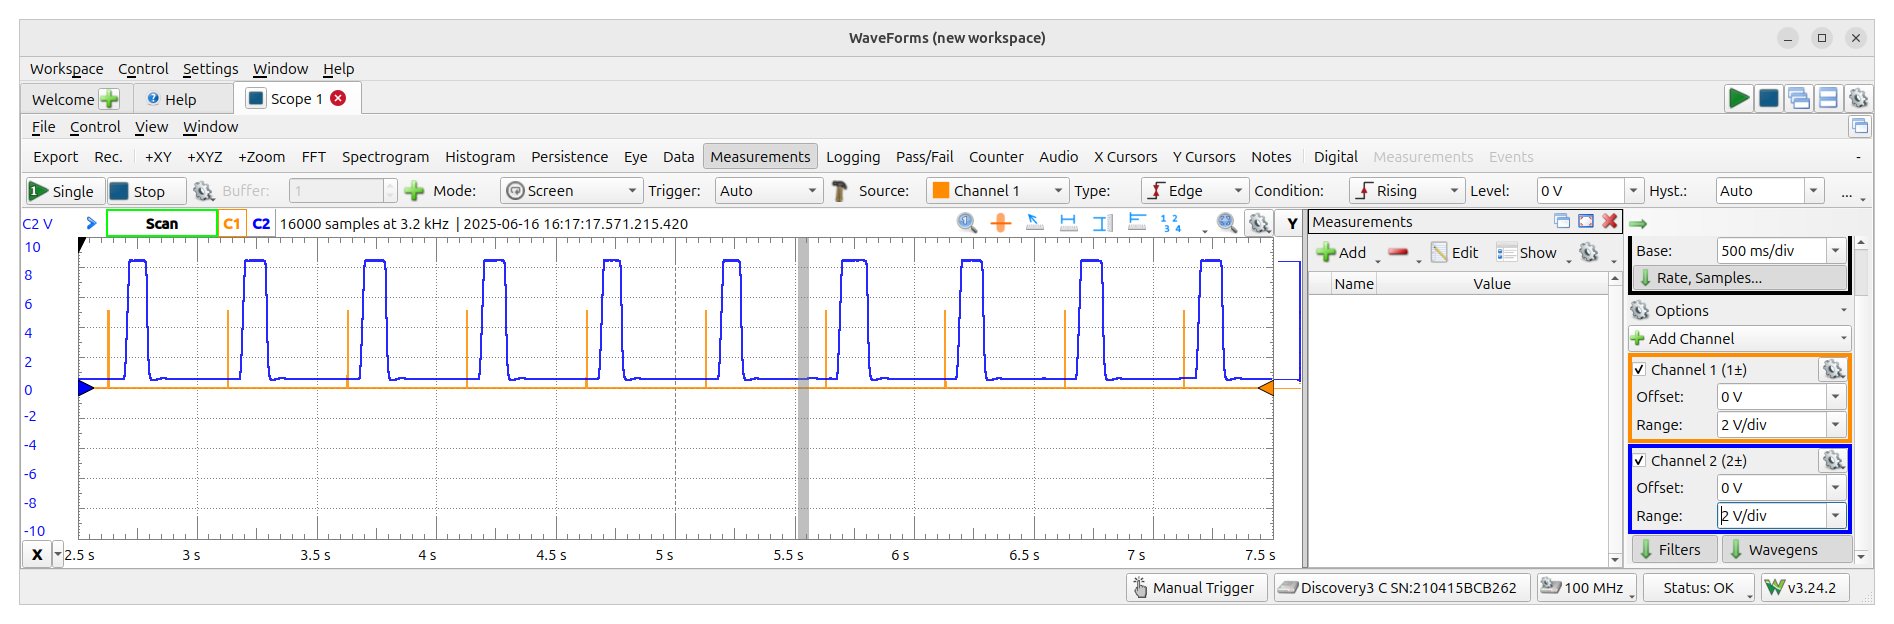
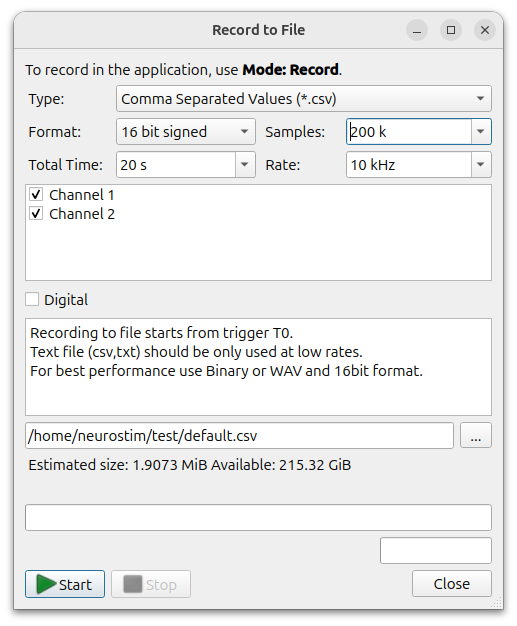